In [408]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint

# Game Theory

The following algorithm is inspired by the report *An epidemiological model with voluntary quarantine strategies governed by evolutionary game dynamics* (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8044925/).

In [418]:
k = 0.1                             # Irrationality constant of the Fermi rule
a = 0.1                             # Control parameter that determines the likelihood of cross-infection
OMEGA = 1                           # cooperator perceived cost
TAU = 1                             # rate at which one adopts a new strategy
GAMMA = 1                           # probability of recovery
BETAQ = 1                           # cooperator infection probability
BETAN = 10                          # defector infection probability
BETAA = a*(BETAQ + BETAN)/2         # average infection probability
DELTA = 10                          # perceived disease cost

def payoff_c():         # cooperator perceived payoff
    return -OMEGA

def payoff_d(subpop):   # defector perceived payoff
    return -DELTA*BETAN*subpop

def fermi(payoff_i, payoff_j):      # fermi's rule of transition probability
    return 1/(1 + np.exp(-(payoff_j - payoff_i)/k))

def conversion_rate_s(s_c, s_d, e_c, e_d, i_c, i_d, payoff_c, payoff_d):
    return s_c*(s_d + e_d + i_d)*fermi(payoff_c, payoff_d) - s_d*(s_c + e_c + i_c)*fermi(payoff_d, payoff_c)

def conversion_rate_e(s_c, s_d, e_c, e_d, i_c, i_d, payoff_c, payoff_d):
    return e_c*(s_d + e_d + i_d)*fermi(payoff_c, payoff_d) - e_d*(s_c + e_c + i_c)*fermi(payoff_d, payoff_c)

def conversion_rate_i(s_c, s_d, e_c, e_d, i_c, i_d, payoff_c, payoff_d):
    return i_c*(s_d + e_d + i_d)*fermi(payoff_c, payoff_d) - i_d*(s_c + e_c + i_c)*fermi(payoff_d, payoff_c)

def generate_gt_SEIR(current_state, t):     # generate the differential equations
    s_c, s_d, e_c, e_d, i_c, i_d, r = current_state

    dscdt = -s_c * (BETAQ * e_c + BETAA * e_d) - TAU * conversion_rate_s(s_c, s_d, e_c, e_d, i_c, i_d, payoff_c(), payoff_d(e_c + e_d))
    dsddt = -s_d * (BETAA * e_c + BETAN * e_d) + TAU * conversion_rate_s(s_c, s_d, e_c, e_d, i_c, i_d, payoff_c(), payoff_d(e_c + e_d))
    decdt = s_c * (BETAQ * e_c + BETAA * e_d) - GAMMA * e_c - TAU * conversion_rate_e(s_c, s_d, e_c, e_d, i_c, i_d, payoff_c(), payoff_d(i_c + i_d))
    deddt = s_d * (BETAA * e_c + BETAN * e_d) - GAMMA * e_d + TAU * conversion_rate_e(s_c, s_d, e_c, e_d, i_c, i_d, payoff_c(), payoff_d(i_c + i_d))
    dicdt = e_c - GAMMA * i_c - TAU * conversion_rate_i(s_c, s_d, e_c, e_d, i_c, i_d, payoff_c(), payoff_d(i_c + i_d))
    diddt = e_d - GAMMA * i_d + TAU * conversion_rate_i(s_c, s_d, e_c, e_d, i_c, i_d, payoff_c(), payoff_d(i_c + i_d))
    drdt = GAMMA * (i_d + i_c)
    
    return dscdt, dsddt, decdt, deddt, dicdt, diddt, drdt

def solve_by_odeint(timesteps, initial_state):
    ssiir = odeint(generate_gt_SEIR, initial_state, timesteps)

    s_c = ssiir[:, 0]
    s_d = ssiir[:, 1]
    e_c = ssiir[:, 2]
    e_d = ssiir[:, 3]
    i_c = ssiir[:, 4]
    i_d = ssiir[:, 5]
    r = ssiir[:, 6]
    
    return s_c, s_d, e_c, e_d, i_c, i_d, r

def plot_SIR(t, SIR):
    fig = plt.figure(figsize=(12, 9))
    plt.plot(t, SIR[0] + SIR[1], label='S')
    plt.plot(t, SIR[2] + SIR[3], label='E')
    plt.plot(t, SIR[4] + SIR[5], label='I')
    plt.plot(t, SIR[6], label='R')
    plt.legend()
    plt.grid()
    plt.title('Evolution of Population Over Time')
    plt.xlabel('Time')
    plt.ylabel('Population Fraction')

def plot_subpopulation(t, SIR):
    fig = plt.figure(figsize=(12, 9))
    plt.plot(t, SIR[0], label='SC')
    plt.plot(t, SIR[1], label='SD')
    plt.plot(t, SIR[2], label='EC')
    plt.plot(t, SIR[3], label='ED')
    plt.plot(t, SIR[4], label='IC')
    plt.plot(t, SIR[5], label='ID')
    plt.plot(t, SIR[6], label='R')
    plt.legend()
    plt.grid()
    plt.title('Evolution of Subpopulations Over Time')
    plt.xlabel('Time')
    plt.ylabel('Population Fraction')


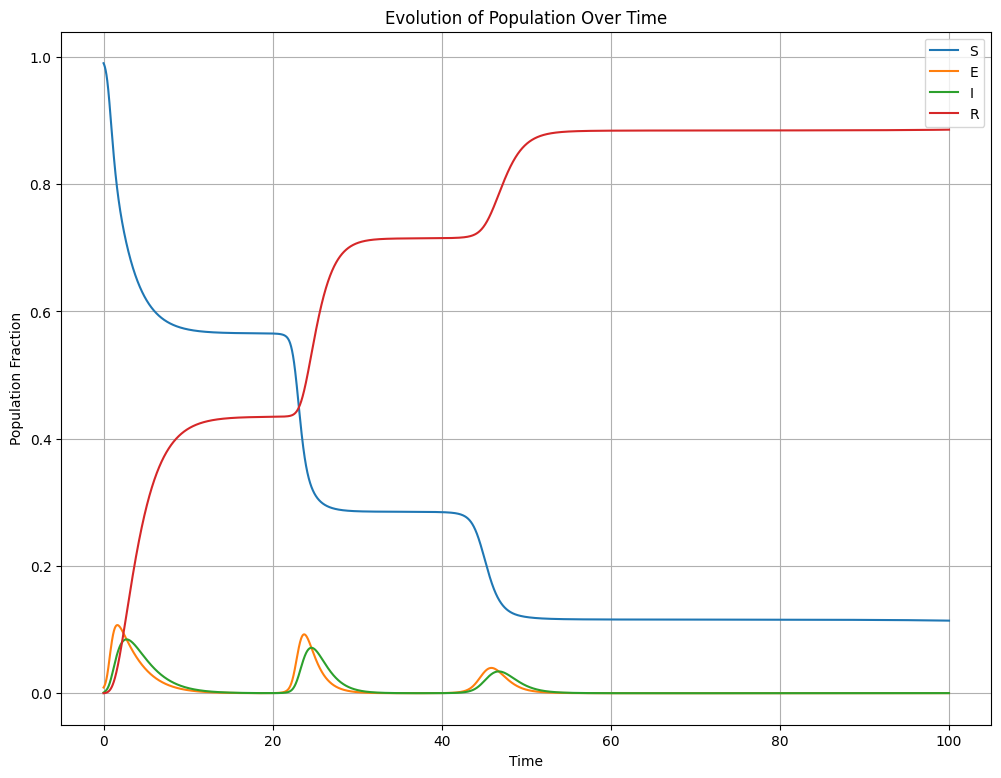

In [423]:
C0 = 0.5          			# initial fraction of Cooperators
D0 = 1-C0         			# initial fraction of Defectors
S0 = 0.99         			# initial susceptibles
E0 = 0.9*(1-S0)             # initial fraction of Exposed
I0 = 0.1*(1-S0)             # initial fraction of Infected
R0 = 0            			# initial fraction of Recovered

sc0 = S0*C0
sd0 = S0*D0
ec0 = E0*C0
ed0 = E0*D0
ic0 = I0*C0
id0 = I0*D0
r0 = 0

TIMESTEPS = np.linspace(0, 100, 10000)
initial_state = np.array([sc0, sd0, ec0, ed0, ic0, id0, r0])

SIR = solve_by_odeint(TIMESTEPS, initial_state)
plot_SIR(TIMESTEPS, SIR)


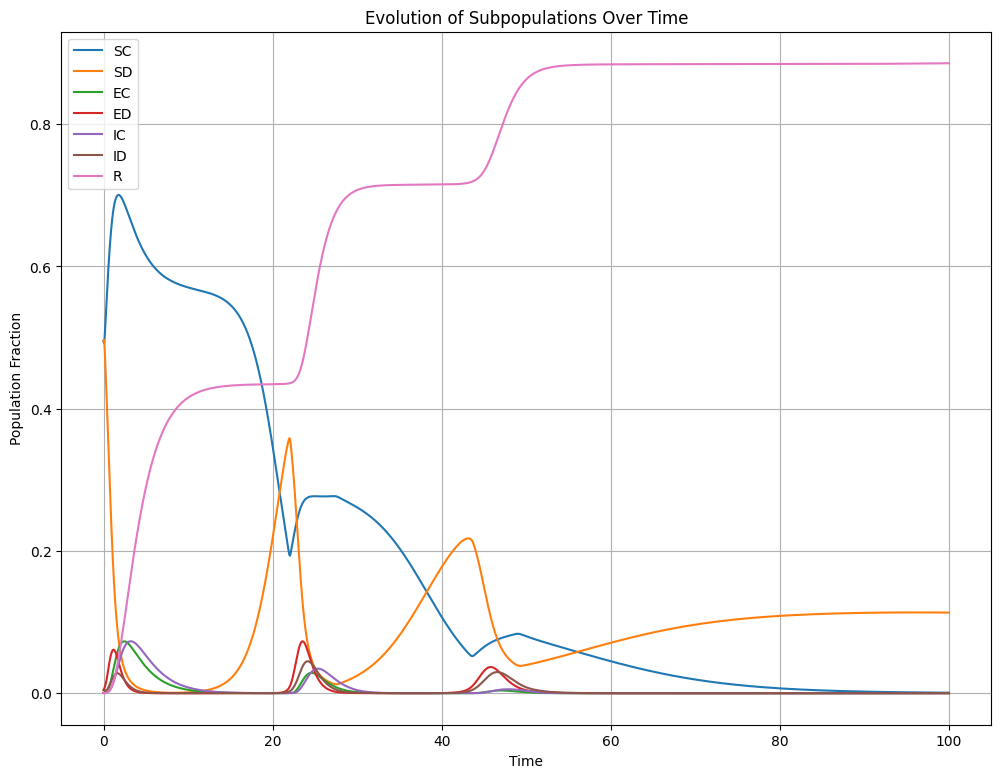

In [424]:
plot_subpopulation(TIMESTEPS, SIR)

# Genetic Algorithm

### Disclaimer
This algorithm was inspired by the report titled *Application of genetic algorithm combined with improved SEIR model in predicting the epidemic trend of COVID-19, China*. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9133826/)

In this report (and my project), genetic algorithm is used to optimize loosely defined parameters by using the root mean square error of the simulated infected population and the actual infected population, which I collected separately from the official website of Wuhan Municipal Health Commision (http://wjw.wuhan.gov.cn/), as the fitness function. However, I was unable to implement the genetic algorithm correctly. Therefore, in order to still produce meaningful results, I used the already-optimized parameters from the referenced report, defined as constants, to show what the result of implementing genetic algorithm would be. I will also be modifying these parameters manually to demonstrate the sensitivity of these parameters, as well their effects. These will be further detailed in my report.

In [415]:
Iraw = np.array([80, 892, 315, 356, 378, 576, 894, 1033, 1242, 1967, 1766, 1501, 1985, 1379, 1921, 1552, 1104, 13436, 3910, 1923, 1548, 1690, 1600, 1660, 615, 319, 314, 541, 348, 464, 370, 383, 313, 420, 565, 193, 111, 114, 131, 126, 74, 41, 36, 17, 13, 8, 5, 4, 4, 4, 1, 1, 6, 2, 6, 4, 9, 1, 0, 0, 0, 0, 0, 0, 0, 1])
RREAL_WH = np.array([20, 22, 19, 32, 51, 69, 64, 94, 127, 114, 115, 167, 231, 242, 240, 229, 243, 754, 458, 593, 523, 619, 833, 792, 641, 865, 1082, 1047, 903, 1447, 1498, 1554, 2526, 1763, 1701, 1990, 1870, 1890, 1449, 1061, 1178, 1280, 1181, 914, 1231, 1060, 1109, 1264, 1191, 765, 847, 822, 733, 624, 502, 463, 434, 433, 474, 387, 527, 363, 472, 319, 270, 178])
IREAL_WH = []
temp = Iraw - RREAL_WH

for i in range(len(Iraw)):
    IREAL_WH.append(sum(temp[:i]))  

In [416]:
TOTAL_POPULATION = 11081000
INCUBATION_PERIOD = 7
ALPHA = 1/INCUBATION_PERIOD     # incidence probability of the exposed

Q_E = 0.7                       # isolation rate of the exposed
Q_I = 1                         # isolation rate of the infected
MU = 14                         # isolation period

Q_S = 0.0046                    # proportion of close contacts isolated
R1 = 4.6701                     # number of effective contacts of the infected
R2 = 4.1396                     # number of effective contacts of the exposed
BETAI = 0.4896                  # probability of transmission from I to S
BETAE = 0.0244                  # probability of transmission from E to S
GAMMAII = 0.0752                # recovery rate of isolated infected persons
GAMMAI = 0.7522                 # recovery rate of infected persons


def inititial_ga_SEIR():        # for the first 14 days
    s_next = lambda sir:  sir[0] - R1 * BETAI * sir[4] * sir[0] / TOTAL_POPULATION - R2 * BETAE * sir[2] * sir[0] / TOTAL_POPULATION
    si_next = lambda sir: sir[1]
    e_next = lambda sir:  sir[2] + R1 * BETAI * sir[4] * sir[0] / TOTAL_POPULATION + R2 * BETAE * sir[2] * sir[0] / TOTAL_POPULATION - ALPHA * sir[2]
    ei_next = lambda sir: sir[3]
    i_next = lambda sir:  sir[4] + ALPHA * sir[2] - GAMMAI * sir[4]
    ii_next = lambda sir: sir[5]
    r_next = lambda sir:  sir[6] + GAMMAI * sir[4]

    return s_next, si_next, e_next, ei_next, i_next, ii_next, r_next

def incubation_ga_SEIR():  # for after the first 14 days
    s_next = lambda sir:  sir[0] - (sir[0]/(TOTAL_POPULATION - sir[1] - sir[3] - sir[5])) * (R1 * sir[4] * (BETAI + Q_S - BETAI * Q_S) + R2 * sir[2] * (BETAE + Q_S - BETAE * Q_S))
    si_next = lambda sir: sir[1] + (sir[0]/(TOTAL_POPULATION - sir[1] - sir[3] - sir[5])) * Q_S * (R1 * sir[4] * (1 - BETAI) + R2 * sir[2] * (1 - BETAE))
    e_next = lambda sir:  sir[2] + (sir[0]/(TOTAL_POPULATION - sir[1] - sir[3] - sir[5])) * (R1 * BETAI * sir[4] + R2 * BETAE * sir[2]) - ALPHA * sir[2] * (1 - Q_E) - Q_E * sir[2]
    ei_next = lambda sir: sir[3] + Q_E * sir[2] - ALPHA * sir[3]
    i_next = lambda sir:  sir[4] + ALPHA * sir[2] * (1 - Q_E) - Q_I * sir[4]
    ii_next = lambda sir: sir[5] + ALPHA * sir[3] + Q_I * sir[4] - GAMMAII * sir[5]
    r_next = lambda sir:  sir[6] + GAMMAII * sir[5]
    
    return s_next, si_next, e_next, ei_next, i_next, ii_next, r_next
    
def plot_SIR(t, SIR):
    fig = plt.figure(figsize=(12, 9))
    # plt.plot(t, SIR[0] + SIR[1], label='S')
    plt.plot(t, SIR[2] + SIR[3], label='E')
    plt.plot(t, SIR[4] + SIR[5], label='I')
    plt.plot(t, SIR[6], label='R')
    plt.legend()
    plt.grid()
    plt.title('Evolution of Population Over Time')
    plt.xlabel('Time')
    plt.ylabel('Population')

def plot_against_real(t, SIR):
    fig = plt.figure(figsize=(12, 9))
    # plt.plot(t, SIR[0] + SIR[1], label='S')
    plt.plot(np.linspace(0, 66, 66), IREAL_WH, label='real')
    plt.plot(np.linspace(0, 66, 66), SIR[4] + SIR[5], label='simulated')
    plt.legend()
    plt.grid()
    plt.title('Number of Infected Individuals Over Time')
    plt.xlabel('Time')
    plt.ylabel('Infected Individuals')

def fitness(SIR):
    return np.sqrt(np.average(SIR[4] + SIR[5] - IREAL_WH)**2)

def discrete_ga_SEIR(timesteps, initial_state):
    s = np.zeros(timesteps)
    si = np.zeros(timesteps)
    e = np.zeros(timesteps)
    ei = np.zeros(timesteps)
    i = np.zeros(timesteps)
    ii = np.zeros(timesteps)
    r = np.zeros(timesteps)

    s[0], si[0], e[0], ei[0], i[0], ii[0], r[0] = initial_state

    s_next, si_next, e_next, ei_next, i_next, ii_next, r_next = inititial_ga_SEIR()
    
    s_next_inc, si_next_inc, e_next_inc, ei_next_inc, i_next_inc, ii_next_inc, r_next_inc = incubation_ga_SEIR()

    for j in range(timesteps - 1):
        sir = (s[j], si[j], e[j], ei[j], i[j], ii[j], r[j])
        if j < MU:
            s[j + 1] = s_next(sir)
            si[j + 1] = si_next(sir)
            e[j + 1] = e_next(sir)
            ei[j + 1] = ei_next(sir)
            i[j + 1] = i_next(sir)
            ii[j + 1] = ii_next(sir)
            r[j + 1] = r_next(sir)
        elif j < 2 * MU:
            s[j + 1] = s_next_inc(sir)
            si[j + 1] = si_next_inc(sir)
            e[j + 1] = e_next_inc(sir)
            ei[j + 1] = ei_next_inc(sir)
            i[j + 1] = i_next_inc(sir)
            ii[j + 1] = ii_next_inc(sir)
            r[j + 1] = r_next_inc(sir)
        else:
            s[j + 1] = s_next_inc(sir) + si[j-MU]
            si[j + 1] = si_next_inc(sir) - si[j-MU]
            e[j + 1] = e_next_inc(sir)
            ei[j + 1] = ei_next_inc(sir)
            i[j + 1] = i_next_inc(sir)
            ii[j + 1] = ii_next_inc(sir)
            r[j + 1] = r_next_inc(sir)

        SIR = np.array([s, si, e, ei, i, ii, r])

    t = np.linspace(0, timesteps, timesteps)
    SIR = np.array([s, si, e, ei, i, ii, r])
    plot_SIR(t, SIR)
    plot_against_real(t, SIR)

    return SIR


68.1498399144431


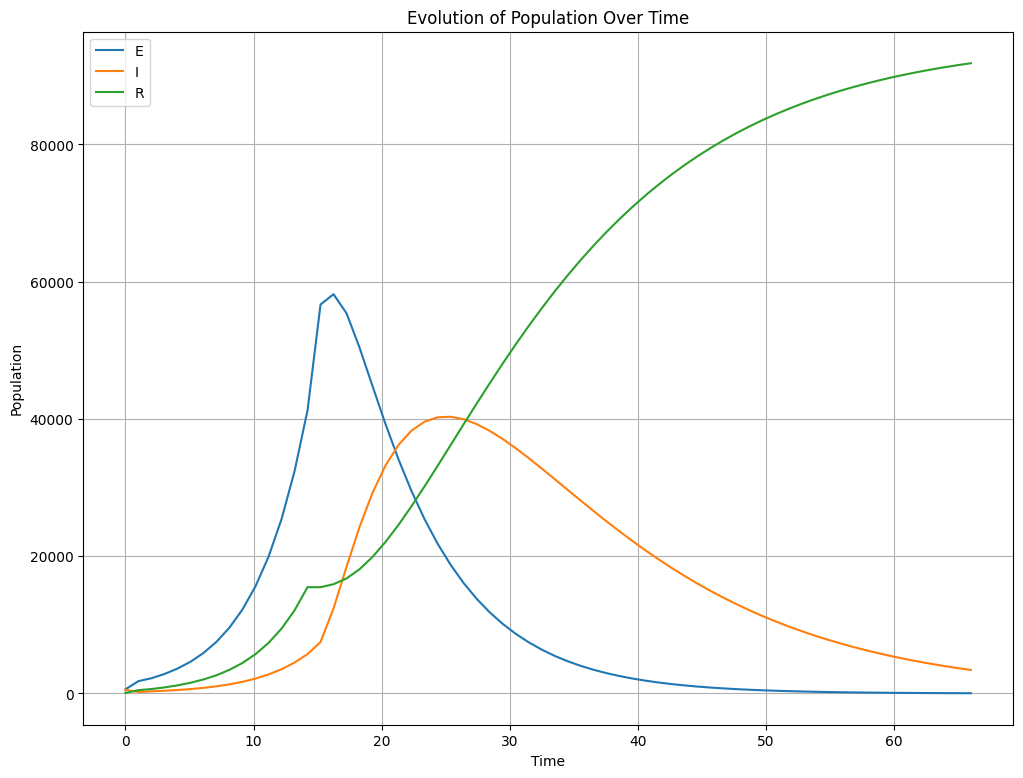

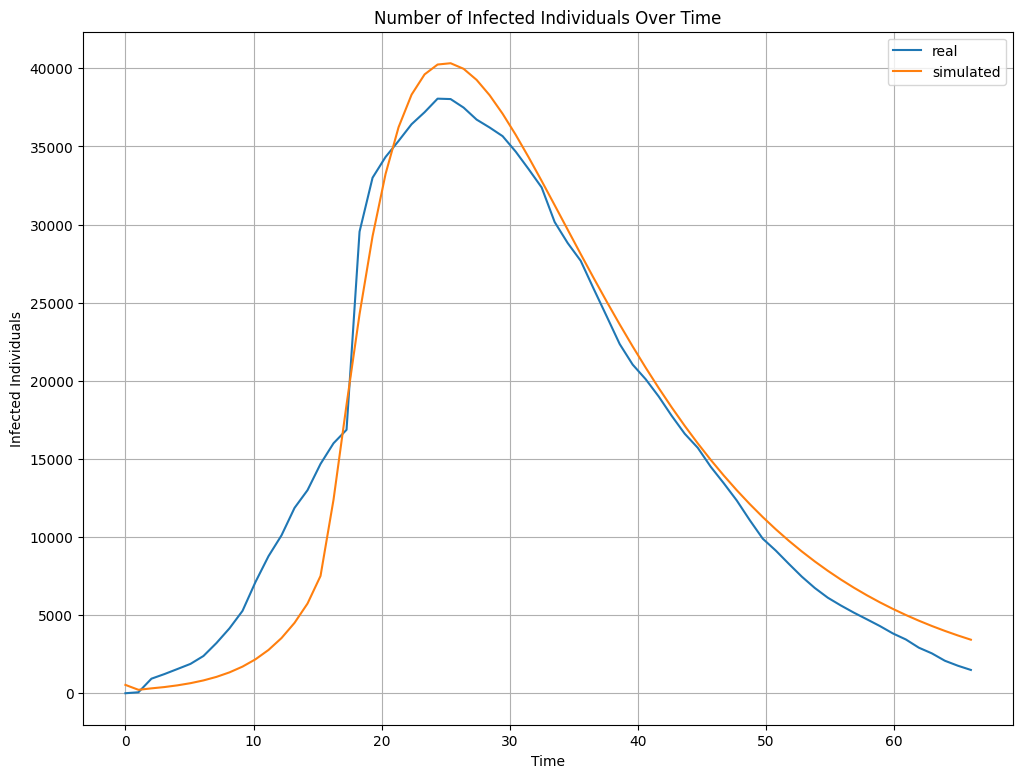

In [417]:
# TIMESTEPS = np.linspace(0, 70, 10000)
initial_state = np.array([TOTAL_POPULATION, 0, 606, 0, 533, 0, 85])

# SIR = solve_ga_by_odeint(TIMESTEPS, initial_state)

# plot_SIR(TIMESTEPS, SIR)
TIMESTEPS = 66
SIR = discrete_ga_SEIR(TIMESTEPS, initial_state)
print(fitness(SIR))
